# Hypothesis testing - Web site light/dark theme
This notebook is HIGHLY inspired from this article https://thecleverprogrammer.com/2023/07/24/a-b-testing-of-themes-using-python/

The goal is to check whether a light or dark them of a bookstore website has an impact on the book sales.

Get the data 

In [1]:
!wget https://statso.io/wp-content/uploads/2023/07/website_ab_test.csv

--2024-06-25 09:50:13--  https://statso.io/wp-content/uploads/2023/07/website_ab_test.csv
Resolving statso.io (statso.io)... 192.0.78.171, 192.0.78.225
Connecting to statso.io (statso.io)|192.0.78.171|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110907 (108K) [text/csv]
Saving to: ‘website_ab_test.csv’

website_ab_test.csv 100%[===================>] 108,31K  --.-KB/s    in 0,05s   

2024-06-25 09:50:14 (2,08 MB/s) - ‘website_ab_test.csv’ saved [110907/110907]



In [ ]:
#install dependencies
%pip install plotly pandas scipy seaborn

In [50]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
from statsmodels.stats.proportion import proportions_ztest
from scipy import stats
import seaborn as sns
import numpy as np

sns.set_theme(style="darkgrid")


In [2]:
data = pd.read_csv("website_ab_test.csv")
print(data.head())

         Theme  Click Through Rate  Conversion Rate  Bounce Rate  \
0  Light Theme            0.054920         0.282367     0.405085   
1  Light Theme            0.113932         0.032973     0.732759   
2   Dark Theme            0.323352         0.178763     0.296543   
3  Light Theme            0.485836         0.325225     0.245001   
4  Light Theme            0.034783         0.196766     0.765100   

   Scroll_Depth  Age   Location  Session_Duration Purchases Added_to_Cart  
0     72.489458   25    Chennai              1535        No           Yes  
1     61.858568   19       Pune               303        No           Yes  
2     45.737376   47    Chennai               563       Yes           Yes  
3     76.305298   58       Pune               385       Yes            No  
4     48.927407   25  New Delhi              1437        No            No  


Check if data has null value

In [3]:
print(data.isnull().sum())

Theme                 0
Click Through Rate    0
Conversion Rate       0
Bounce Rate           0
Scroll_Depth          0
Age                   0
Location              0
Session_Duration      0
Purchases             0
Added_to_Cart         0
dtype: int64


In [4]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Theme               1000 non-null   object 
 1   Click Through Rate  1000 non-null   float64
 2   Conversion Rate     1000 non-null   float64
 3   Bounce Rate         1000 non-null   float64
 4   Scroll_Depth        1000 non-null   float64
 5   Age                 1000 non-null   int64  
 6   Location            1000 non-null   object 
 7   Session_Duration    1000 non-null   int64  
 8   Purchases           1000 non-null   object 
 9   Added_to_Cart       1000 non-null   object 
dtypes: float64(4), int64(2), object(4)
memory usage: 78.3+ KB
None


In [5]:
print(data.describe())

       Click Through Rate  Conversion Rate  Bounce Rate  Scroll_Depth  \
count         1000.000000      1000.000000  1000.000000   1000.000000   
mean             0.256048         0.253312     0.505758     50.319494   
std              0.139265         0.139092     0.172195     16.895269   
min              0.010767         0.010881     0.200720     20.011738   
25%              0.140794         0.131564     0.353609     35.655167   
50%              0.253715         0.252823     0.514049     51.130712   
75%              0.370674         0.373040     0.648557     64.666258   
max              0.499989         0.498916     0.799658     79.997108   

               Age  Session_Duration  
count  1000.000000       1000.000000  
mean     41.528000        924.999000  
std      14.114334        508.231723  
min      18.000000         38.000000  
25%      29.000000        466.500000  
50%      42.000000        931.000000  
75%      54.000000       1375.250000  
max      65.000000       1797.

## Compare Conversion rates between light/dark themes

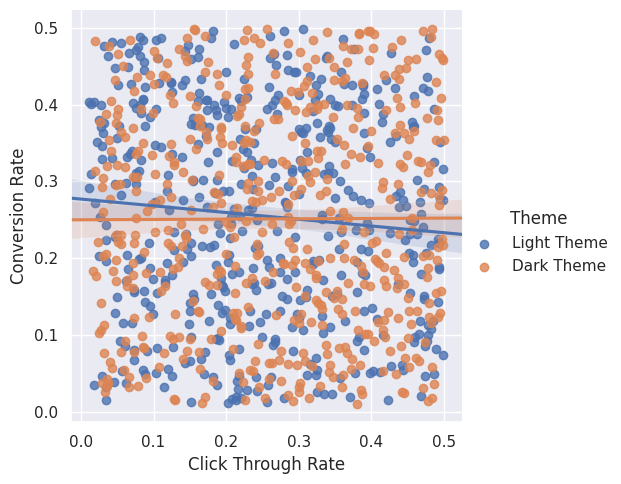

In [20]:
# Scatter plot for Click Through Rate and Conversion Rate
g = sns.lmplot(x='Click Through Rate',  y='Conversion Rate', data=data,
                  truncate=False, hue='Theme')               


It seems that there is no correlation between the CTR and the conversion rate, i.e., does not matter if a user click on a few or a lot of links, they have the same conversion rate.

### Conversion rate histogram

<Axes: xlabel='Conversion Rate', ylabel='Count'>

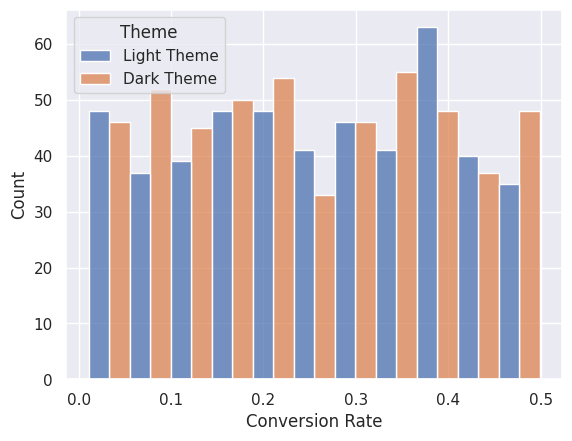

In [29]:
# Extract data for each theme
light_theme_data = data[data['Theme'] == 'Light Theme']
dark_theme_data = data[data['Theme'] == 'Dark Theme']
sns.histplot(
    data=data, x='Conversion Rate', hue='Theme', multiple='dodge',
)

## Compare Click through rate

<Axes: xlabel='Click Through Rate', ylabel='Count'>

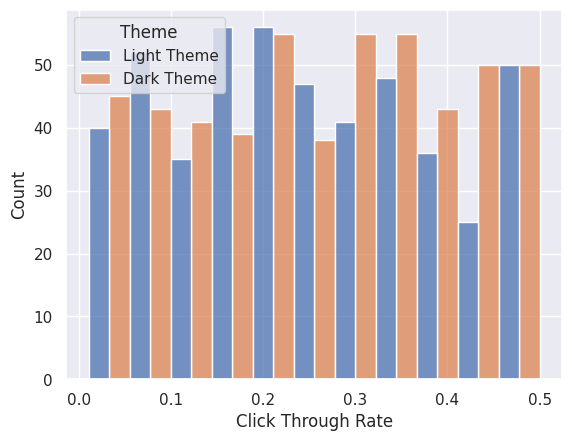

In [28]:
# Extract data for each theme
light_theme_data = data[data['Theme'] == 'Light Theme']
dark_theme_data = data[data['Theme'] == 'Dark Theme']
sns.histplot(
    data=data, x='Click Through Rate', hue='Theme', multiple='dodge',
)

It seems from the above hist that there is no differences between both them wrt to the CTR.
Let's check the conversion Rate

## Compare Bounce rate

<Axes: ylabel='Bounce Rate'>

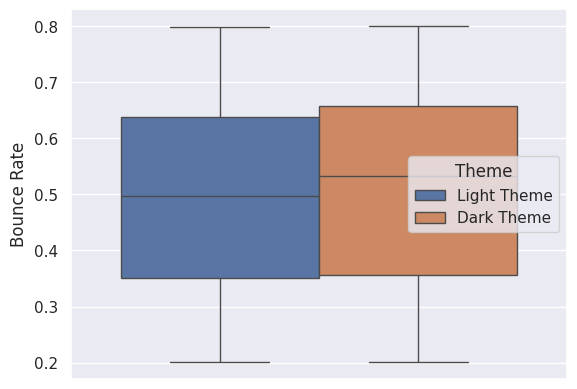

In [35]:
sns.boxplot(data=data, y='Bounce Rate', hue='Theme')

Bounce Rate is slightly higher for dark theme, but there's not much differences

## Compare Scroll Depth

<Axes: ylabel='Scroll_Depth'>

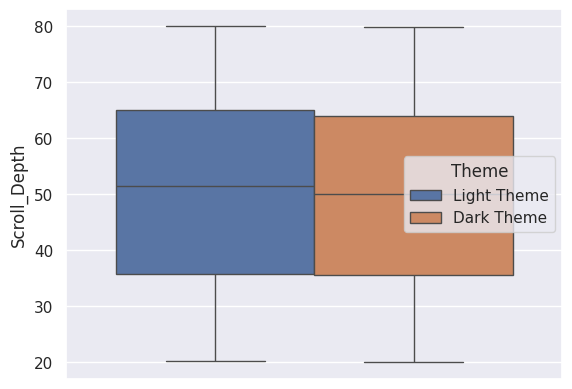

In [37]:
sns.boxplot(data=data, y='Scroll_Depth', hue='Theme')

## Comparison of both themes based on purchases

In [38]:
# A/B testing for Purchases
light_theme_conversions = light_theme_data[light_theme_data['Purchases'] == 'Yes'].shape[0]
light_theme_total = light_theme_data.shape[0]

dark_theme_conversions = dark_theme_data[dark_theme_data['Purchases'] == 'Yes'].shape[0]
dark_theme_total = dark_theme_data.shape[0]

conversion_counts = [light_theme_conversions, dark_theme_conversions]
sample_sizes = [light_theme_total, dark_theme_total]

light_theme_conversion_rate = light_theme_conversions / light_theme_total
dark_theme_conversion_rate = dark_theme_conversions / dark_theme_total


In [44]:
# Perform two-sample proportion test
zstat, pval = proportions_ztest(conversion_counts, sample_sizes)
print("Light Theme Conversion Purchase:", light_theme_conversions)
print("Light Theme Total:", light_theme_total)
print("Light Theme Conversion Rate:", light_theme_conversion_rate)
print("Dark Theme Conversion Purchase:", dark_theme_conversions)
print("Dark Theme Total:", dark_theme_total)
print("Dark Theme Conversion Rate:", dark_theme_conversion_rate)
print("A/B Testing - z-statistic:", zstat, " p-value:", pval)

Light Theme Conversion Purchase: 258
Light Theme Total: 486
Light Theme Conversion Rate: 0.5308641975308642
Dark Theme Conversion Purchase: 259
Dark Theme Total: 514
Dark Theme Conversion Rate: 0.5038910505836576
A/B Testing - z-statistic: 0.8531246206222649  p-value: 0.39359019934127804


The z-statistics telle that the Dark Theme mean CR falls 0.85 standard deviation below the Light Theme mean CR. 
The p-value indicates the probability to observe more extreme difference between the light and dark mean CR. 
From the above results, we cannot conclude that any of the theme has a higher CR than the other.

## Comparison of both themes based on session duration

In [40]:
light_theme_session_duration = light_theme_data['Session_Duration']
dark_theme_session_duration = dark_theme_data['Session_Duration']

# Calculate the average session duration for both themes
light_theme_avg_duration = light_theme_session_duration.mean()
dark_theme_avg_duration = dark_theme_session_duration.mean()

# Print the average session duration for both themes
print("Light Theme Average Session Duration:", light_theme_avg_duration)
print("Dark Theme Average Session Duration:", dark_theme_avg_duration)

# Perform two-sample t-test for session duration
tstat, pval = stats.ttest_ind(light_theme_session_duration, dark_theme_session_duration)
print("A/B Testing for Session Duration - t-statistic:", tstat, " p-value:", pval)

Light Theme Average Session Duration: 930.8333333333334
Dark Theme Average Session Duration: 919.4824902723735
A/B Testing for Session Duration - t-statistic: 0.3528382474155483  p-value: 0.7242842138292167


The t-statistics telle that the Dark Theme mean session duration falls 0.35 standard deviation below the Light Theme mean session duration. 
The p-value indicates the probability to observe more extreme difference between the light and dark mean CR. 
From the above results, we cannot conclude that any of the theme has a significant higher session duration than the other.